In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization,Cropping2D
from tensorflow.keras.models import Model
import random
import tensorflow as tf

In [2]:
# Đọc tệp Excel vào DataFrame
file_path = "/kaggle/input/btxrd-final1/classification.xlsx"  # Đường dẫn đến file Excel
df = pd.read_excel(file_path)

# Đường dẫn thư mục ảnh và mask
image_path = '/kaggle/input/btxrd-final1/images'
mask_path = '/kaggle/input/btxrd-final1/masks'
print(mask_path)

/kaggle/input/btxrd-final1/masks


In [3]:
# Lọc những ảnh có mask
df_with_mask = df[df['mask_flag'] == 1]

# Chia train, test, valid
df_train = df_with_mask[df_with_mask['tumor_category'] == 1].copy()
df_test  = df_with_mask[df_with_mask['tumor_category'] == 2].copy()
df_valid = df_with_mask[df_with_mask['tumor_category'] == 3].copy()
print("Chia tệp dữ liệu thành công")

Chia tệp dữ liệu thành công


In [4]:
# Tạo cột đường dẫn
df_train['image_path'] = df_train['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_train['mask_path']  = df_train['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

df_test['image_path'] = df_test['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_test['mask_path']  = df_test['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

df_valid['image_path'] = df_valid['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_valid['mask_path']  = df_valid['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

print("dfasdfd")

dfasdfd


In [5]:
# Hàm load ảnh và mask
def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    
    image = tf.image.resize(image, (224, 224))
    mask = tf.image.resize(mask, (224, 224))
    return image, mask

# Chọn batch size random trước
BATCH_SIZE = random.choice([8, 16, 32, 64])

# Tạo datasets
train_dataset = tf.data.Dataset.from_tensor_slices((df_train['image_path'], df_train['mask_path']))
train_dataset = train_dataset.map(load_image_and_mask)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((df_valid['image_path'], df_valid['mask_path']))
val_dataset = val_dataset.map(load_image_and_mask)
val_dataset = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((df_test['image_path'], df_test['mask_path']))
test_dataset = test_dataset.map(load_image_and_mask)
test_dataset = test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
print("load data thành công")

load data thành công


Train batch shape:
Image batch shape: (16, 224, 224, 1)
Mask batch shape: (16, 224, 224, 1)


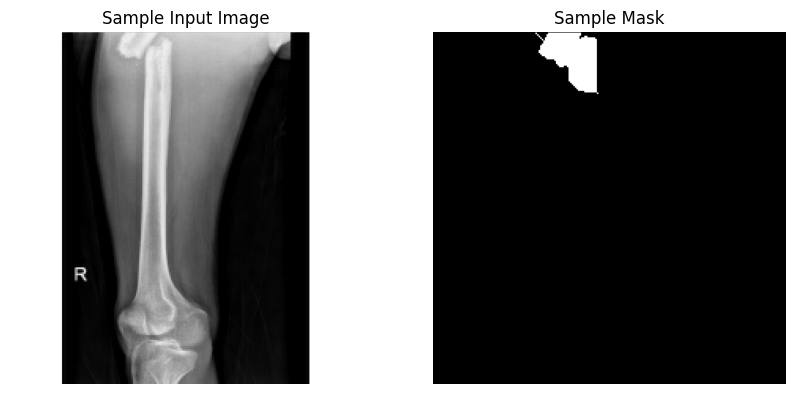

Validation batch shape:
Image batch shape: (16, 224, 224, 1)
Mask batch shape: (16, 224, 224, 1)


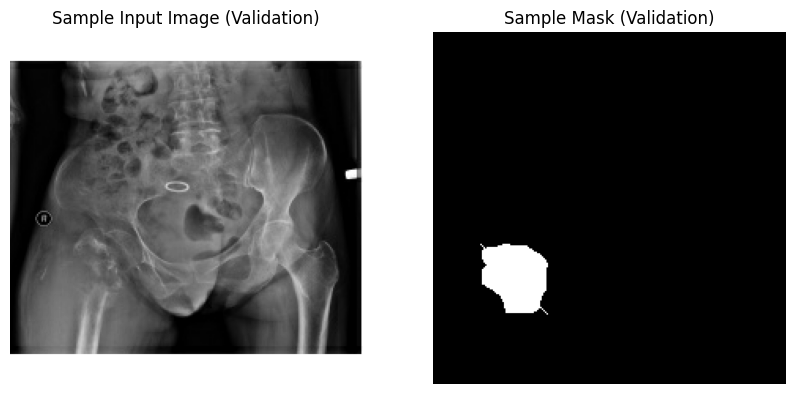

Test batch shape:
Image batch shape: (16, 224, 224, 1)
Mask batch shape: (16, 224, 224, 1)


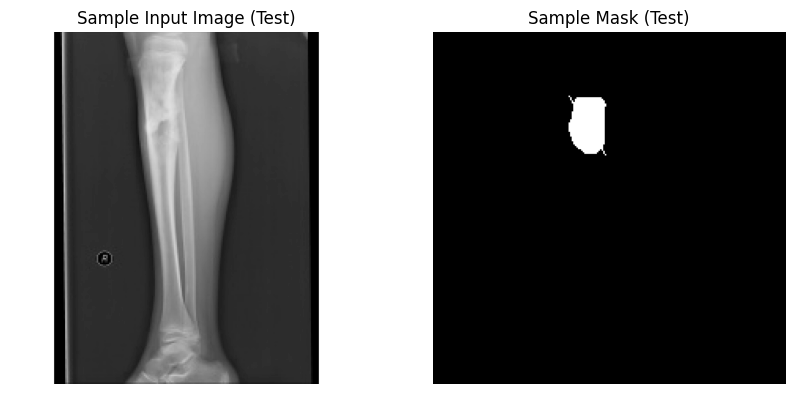

In [6]:
import matplotlib.pyplot as plt

# Kiểm tra một batch từ train_dataset
for images, masks in train_dataset.take(1):  # Lấy 1 batch từ train_dataset
    print("Train batch shape:")
    print("Image batch shape:", images.shape)  # Kích thước của batch ảnh
    print("Mask batch shape:", masks.shape)    # Kích thước của batch mask

    # Hiển thị một ảnh và mask
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')  # Hiển thị ảnh đầu tiên trong batch (1 channel)
    plt.title("Sample Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')  # Hiển thị mask đầu tiên trong batch (1 channel)
    plt.title("Sample Mask")
    plt.axis('off')

    plt.show()
    break  # Dừng sau khi đã kiểm tra 1 batch

# Kiểm tra một batch từ val_dataset
for images, masks in val_dataset.take(1):
    print("Validation batch shape:")
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')
    plt.title("Sample Input Image (Validation)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')
    plt.title("Sample Mask (Validation)")
    plt.axis('off')

    plt.show()
    break

# Kiểm tra một batch từ test_dataset
for images, masks in test_dataset.take(1):
    print("Test batch shape:")
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')
    plt.title("Sample Input Image (Test)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')
    plt.title("Sample Mask (Test)")
    plt.axis('off')

    plt.show()
    break

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ======================
# Loss function: Dice + BCE
# ======================
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def dice_bce_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

# ======================
# Các khối nâng cấp
# ======================
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p

def decoder_block(x, skip, filters):
    up = layers.UpSampling2D((2, 2))(x)
    merge = layers.Concatenate()([up, skip])
    c = conv_block(merge, filters)
    return c

# ======================
# Build model
# ======================
def build_strong_unet(input_shape=(224, 224, 1), num_classes=1):
    inputs = layers.Input(input_shape)

    # Encoder
    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    # Bottleneck
    bn = conv_block(p4, 1024)

    # Decoder
    d4 = decoder_block(bn, c4, 512)
    d3 = decoder_block(d4, c3, 256)
    d2 = decoder_block(d3, c2, 128)
    d1 = decoder_block(d2, c1, 64)

    # Output
    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid')(d1)

    model = models.Model(inputs, outputs)
    return model


In [ ]:
model = build_strong_unet(input_shape=(224, 224, 1))
model.compile(optimizer='adam', loss=dice_bce_loss, metrics=['accuracy'])
model.summary()

# Huấn luyện
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 224, 224, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 224, 224, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 112, 112, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 112, 112, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,401,345 (119.79 MB)

 Trainable params: 31,389,569 (119.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9480 - loss: 1.1587 - val_accuracy: 0.4658 - val_loss: 1.7808
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 59s 696ms/step - accuracy: 0.9721 - loss: 0.9872 - val_accuracy: 0.4801 - val_loss: 2.2269
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 60s 707ms/step - accuracy: 0.9608 - loss: 0.9265 - val_accuracy: 0.5318 - val_loss: 2.0686
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 61s 725ms/step - accuracy: 0.9608 - loss: 0.9105 - val_accuracy: 0.5397 - val_loss: 2.3372
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 62s 740ms/step - accuracy: 0.9658 - loss: 0.8911 - val_accuracy: 0.8450 - val_loss: 1.2540
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 63s 743ms/step - accuracy: 0.9652 - loss: 0.8762 - val_accuracy: 0.9275 - val_loss: 1.0610
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 63s 744ms/step - accuracy: 0.9646 - loss: 0.8702 - val_accuracy: 0.9575 - val_loss: 0.9993
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 62s 740ms/step - accuracy: 0.9696 - loss: 0.8329 - val_accura

In [ ]:
results = model.evaluate(test_dataset)
print(f"Results: {results}")

In [ ]:
# Dự đoán trên test dataset và hiển thị kết quả
for image_batch, mask_batch in test_dataset.take(1):  # Chỉ lấy một batch từ test dataset
    pred_batch = model.predict(image_batch)  # Dự đoán cho batch
    pred_batch = (pred_batch > 0.5).astype(np.float32)  # Chuyển sang nhị phân (0 hoặc 1)

    # Hiển thị ảnh gốc, mask thực tế và mask dự đoán
    plt.figure(figsize=(12, 12))
    for i in range(min(4, len(image_batch))):  # Chỉ hiển thị 4 ảnh đầu tiên
        # Ảnh gốc
        plt.subplot(4, 3, i * 3 + 1)
        plt.imshow(image_batch[i, :, :, 0], cmap='gray')
        plt.title("Image")
        plt.axis('off')

        # Mask thực tế
        plt.subplot(4, 3, i * 3 + 2)
        plt.imshow(mask_batch[i, :, :, 0], cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        # Mask dự đoán
        plt.subplot(4, 3, i * 3 + 3)
        plt.imshow(pred_batch[i, :, :, 0], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Giả sử bạn đã chạy model.fit() và có đối tượng 'history'
# history = model.fit(...)

# Lấy giá trị loss từ history
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Vẽ đồ thị loss huấn luyện
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Nếu bạn có validation loss
if 'val_loss' in history.history:
    val_loss = history.history['val_loss']
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
model.save('unet_model.h5')  # Lưu mô hình dưới dạng file .h5
model.save('/kaggle/working/unet_model.h5')  # Lưu mô hình vào thư mục /kaggle/working

In [ ]:
from IPython.display import FileLink

# Tạo liên kết tải xuống cho file mô hình
FileLink('/kaggle/working/unet_model.h5')